<img src="inputs_outputs.png" width="700" height="100">

<img src="ioshapes.png" width="700" height="100">

<img src="hyperparamater.png" width="500" height="100">

In [1]:
# Make classification data and get it ready(Öğrenmek için kendi datasetimi zaten numeric formatta oluşturdum)
import sklearn
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000
# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
print(f"First 5 samples of X {X[:5]}")
print(f"First 5 samples of Y {y[:5]}")

First 5 samples of X [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of Y [1 1 1 1 0]


In [4]:
# Make a dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0], 
                        "X2": X[:, 1],
                       "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


In [5]:
circles.label.value_counts() # Dataset balance!

1    500
0    500
Name: label, dtype: int64

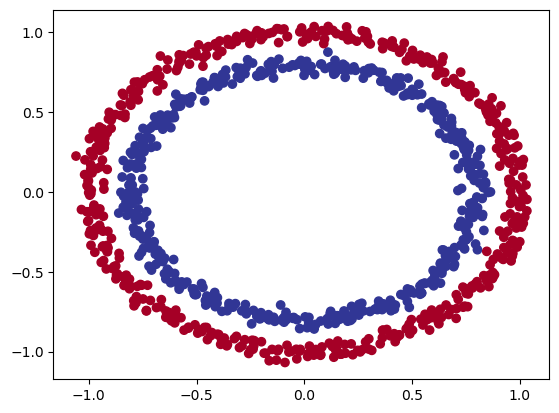

In [6]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)
# Bizim problem noktam mavide mi kırmızıda mı?

In [7]:
X.shape, y.shape

((1000, 2), (1000,))

In [8]:
import torch
torch.__version__

'1.12.1'

In [9]:
type(X), X.dtype #Numpy da default 64 o Tensor da 32. O nedenle aşağıda torch.float kullandım

(numpy.ndarray, dtype('float64'))

In [10]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
# Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

#### Building a model

We've got some data ready, now it's time to build a model.

We'll break it down into a few parts.

* Setting up device agnostic code (so our model can run on CPU or GPU if it's available).
* Constructing a model by subclassing nn.Module.
* Defining a loss function and optimizer.
* Creating a training loop.

In [13]:
device = torch.device("mps")
device

device(type='mps')

### Model
We'll want a model capable of handling our X data as inputs and producing something in the shape of our y data as ouputs.

In other words, given X (features) we want our model to predict y (label).

This setup where you have features and labels is referred to as supervised learning. Because your data is telling your model what the outputs should be given a certain input.

To create such a model it'll need to handle the input and output shapes of X and y.

Let's create a model class that:

* Subclasses nn.Module (almost all PyTorch models are subclasses of nn.Module).
* Creates 2 nn.Linear layers in the constructor capable of handling the input and output shapes of X and y.
* Defines a forward() method containing the forward pass computation of the model.
* Instantiates the model class and sends it to the target device.

In [14]:
y_train[:5]

tensor([1., 0., 0., 0., 1.])

In [15]:
from torch import nn
# X_train.shape = torch.Size([800, 2])   in_features=2
# y_train[:5] = tensor([1., 0., 0., 0., 1.]) out_features=1
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features and upscales to 5 features
        # Bunu 5 yapmam modele daha fazla pattern yakalaması için şans verdi
        # out_features=5 ile in_features=5 eşleşmeli
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # Output y ile aynı shape
    def forward(self, x):
        #x layer 1'a gidiyor. Buradan çıkan output ise layer_2'ye gidiyor oradan da output
        return self.layer_2(self.layer_1(x))
   
    
model_0 = CircleModelV0().to(device=device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

#### Tensorflow Playground
0.57 loss....

<img src="playground.png" width="700" height="100">

#### figjam.new ile tarayıcıda şablon çizebilirsin
<img src="figma.png" width="600" height="100">

In [16]:
# Let's replicate the model above using nn.Sequential()
# Şimdi Sinir ağı yaratmanın daha kolay bir yolu var ona bakalım.
# Forward eklemeden. nn.Module un alt classı değilde nn.Sequential olarak 
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device=device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [17]:
# Hatta bunu alıp class içine koyalım. Aynı model aslında
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.two_linear_layers = nn.Sequential(
            nn.Linear(in_features=2, out_features=5),
            nn.Linear(in_features=5, out_features=1) 
        )
    def forward(self, x):
        #x layer 1'a gidiyor. Buradan çıkan output ise layer_2'ye gidiyor oradan da output
        return self.two_linear_layers(x)
   
    
model_1 = CircleModelV1().to(device=device)
model_1

CircleModelV1(
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [18]:
model_0.state_dict() # 2*5 = 10

/Users/hasangozcu/miniforge3/lib/python3.10/site-packages/torch/_tensor_str.py:103: UserWarning: The operator 'aten::bitwise_and.Tensor_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(tensor_view, torch.isfinite(tensor_view) & tensor_view.ne(0))


OrderedDict([('0.weight',
              tensor([[ 0.4597, -0.1093],
                      [-0.4967, -0.5273],
                      [-0.2656,  0.0941],
                      [-0.0578, -0.4991],
                      [-0.3999,  0.0322]], device='mps:0')),
             ('0.bias',
              tensor([ 0.6154, -0.2722, -0.5421, -0.4279,  0.6754], device='mps:0')),
             ('1.weight',
              tensor([[0.4411, 0.3328, 0.0807, 0.3215, 0.3178]], device='mps:0')),
             ('1.bias', tensor([-0.1397], device='mps:0'))])

In [19]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)} Shape: {X_test.shape}")
print(f"\nFirst 10 predictions: \n {untrained_preds[:10]}")
print(f"\nFirst 10 labels: \n {y_test[:10]}")

# 

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200 Shape: torch.Size([200, 2])

First 10 predictions: 
 tensor([[-0.1270],
        [-0.2792],
        [ 0.2809],
        [-0.2426],
        [ 0.2948],
        [ 0.2018],
        [-0.2379],
        [-0.1252],
        [ 0.2797],
        [-0.2892]], device='mps:0')

First 10 labels: 
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### Setup loss function and optimizer
* different problem types require different loss functions.
* For example, for a regression problem (predicting a number) you might used mean absolute error (MAE) loss.
* And for a binary classification problem (like ours), you'll often use binary cross entropy as the loss function.
* However, the same optimizer function can often be used across different problem spaces.
* For example, the stochastic gradient descent optimizer (SGD, torch.optim.SGD()) can be used for a range of problems, so can too the Adam optimizer (torch.optim.Adam()).

<img src="lossandopt.png" width="700" height="100">

In [20]:
# Loss olarak 	torch.nn.BCELossWithLogits kullanacağım
# nn.BCEWithLogitsLoss şunun gibi bir şey
"""
model_0 = nn.Sequential(
    nn.Sigmoid() # Sigmoid Activation Function
    nn.BCELoss()  # Binary cross entropy
).to(device=device)
Numerical stability sağlıyor!
"""
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss has the Sigmoid activation function built-in
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [21]:
# Calculate Accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # Kaç tane sample da y_true=y_pred
    acc = (correct/len(y_pred))*100
    return acc

Create a train loop;
* Forward pass - The model goes through all of the training data once, performing its forward() function calculations (model(x_train)).
* Calculate the loss - The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are (loss = loss_fn(y_pred, y_train).
* Zero gradients - The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step (optimizer.zero_grad()).
* Perform backpropagation on the loss - Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards" (loss.backward()).
* Step the optimizer (gradient descent) - Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them (optimizer.step()).

In [22]:
# Going to raw logits -> predictions probs -> predictions labels
# Ml de raw logit ne? Model outputs are going to be raw logits
model_0 # Çıktı logit yani

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

* Bu logitleri aktivasyon fonksiyonu(örneğin binary classification için sigmoid, multiclassification için softmax) kullanarak prediction prob lara convert edebilirim
* Sonra modeldeki pred probları round ederek ya da `argmax()` alarak prediction labellere dönüştürebiliriz.

In [23]:
# View the frist 5 outputs of the forward pass on the test data (Herhangi bir aktivasyon fonksiyonu olmadan)
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[-0.1270],
        [-0.2792],
        [ 0.2809],
        [-0.2426],
        [ 0.2948]], device='mps:0')

In [24]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [25]:
# Use the sigmoid activation function for our model logits to turn them into predictions probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4683],
        [0.4307],
        [0.5698],
        [0.4397],
        [0.5732]], device='mps:0')

* If y_pred_probs >= 0.5, y=1 (class 1)
* If y_pred_probs < 0.5, y=0 (class 0)

In [26]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)
y_preds

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]], device='mps:0')

In [27]:
epochs = 100
# Put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Building a training and validation loop
for epoch in range(epochs):
    # Training
    model_0.train()
    
    # Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # sigmoid ile logit i alıp olasılık haline getirdim.
    
    # Calculate loss-acc
    # nn.BCEWithLogitsLoss input olarak raw logits alır
    # nn.BCELoss kullansaydım prediction probability isterdi input olarak. Yani y_logits yerine torch.sigmoid(y_logits)
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    
    # Optimizer zero grad
    optimizer.zero_grad()
    
    # Loss backward (backpropagation)
    loss.backward()
    
    # Optimizer step (Update to parameter to reduce gradient yani GRADIENT DESCENT)
    optimizer.step()
    
    # Testing
    model_0.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        
        # Calculate test loss - acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
        
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss: .5f} | Acc: {acc:.2f}% | Test loss: {test_loss: .5f} | Test_Acc: {test_acc:.2f}% ") 

Epoch: 0 | Loss:  0.70382 | Acc: 49.88% | Test loss:  0.69229 | Test_Acc: 54.50% 
Epoch: 10 | Loss:  0.70141 | Acc: 49.38% | Test loss:  0.69142 | Test_Acc: 54.00% 
Epoch: 20 | Loss:  0.69975 | Acc: 48.88% | Test loss:  0.69098 | Test_Acc: 55.00% 
Epoch: 30 | Loss:  0.69851 | Acc: 49.00% | Test loss:  0.69075 | Test_Acc: 54.50% 
Epoch: 40 | Loss:  0.69754 | Acc: 49.00% | Test loss:  0.69066 | Test_Acc: 54.00% 
Epoch: 50 | Loss:  0.69677 | Acc: 49.50% | Test loss:  0.69066 | Test_Acc: 54.00% 
Epoch: 60 | Loss:  0.69615 | Acc: 49.38% | Test loss:  0.69071 | Test_Acc: 54.00% 
Epoch: 70 | Loss:  0.69565 | Acc: 49.62% | Test loss:  0.69081 | Test_Acc: 53.50% 
Epoch: 80 | Loss:  0.69524 | Acc: 49.62% | Test loss:  0.69094 | Test_Acc: 54.00% 
Epoch: 90 | Loss:  0.69490 | Acc: 49.75% | Test loss:  0.69109 | Test_Acc: 53.00% 


## https://madewithml.com/courses/mlops/orchestration/ 
HARIKA BIR KAYNAK!

In [28]:
# Make predictions and evealuate the model
# Metriclere bakarsak model pekte bir şey öğrenemedi!
import requests
from pathlib import Path

# Download helper functions from Git Repo!(if it s not already downloaded!)
if Path("helper_functions.py").is_file():
    print("helper_functions.py is already exists, skipping download!")
else: 
    print("Downloading helper_functions.py")
    # Githuba gittim file girdim. Raw version a geç request için!
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
from helper_functions import plot_decision_boundary, plot_predictions

helper_functions.py is already exists, skipping download!


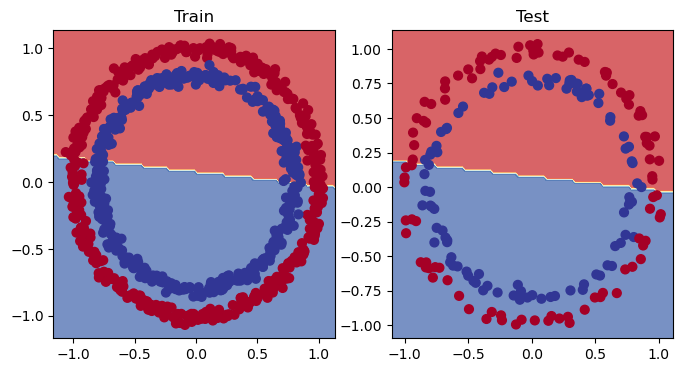

In [29]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0 ,X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0 ,X_test, y_test)
# Model datayı düz bir çizgi olarak bölmüş o nedenle yüzde 50 lerde başarı aldım. Ama datam circle! 
# underfitting problem.

<img src="improvemodel.png" width="600" height="100">

In [30]:
# Modeli geliştirmeye çalışalım;
# Daha fazla hidden unit ekleyelim 5ti onu 10 yapacağım
# Layer sayımı 2 den 3 e çıkaracağım
# Epochs sayımı da 100 den 1000 e çıkaracağım
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
    def forward(self, x):
        return self.layer3(self.layer2(self.layer1(x)))

model_2 = CircleModelV2().to(device)
model_2

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [31]:
model_2.state_dict()

OrderedDict([('layer1.weight',
              tensor([[-0.0775,  0.4806],
                      [ 0.1568,  0.6378],
                      [ 0.4494,  0.4672],
                      [ 0.6540,  0.0410],
                      [ 0.1615, -0.4911],
                      [ 0.1260,  0.2591],
                      [-0.0184,  0.6143],
                      [-0.2781, -0.5795],
                      [-0.1643,  0.0099],
                      [-0.1899,  0.1527]], device='mps:0')),
             ('layer1.bias',
              tensor([-0.3452,  0.2741,  0.1948, -0.6110, -0.2493,  0.3633,  0.5038, -0.3496,
                      -0.5635, -0.2056], device='mps:0')),
             ('layer2.weight',
              tensor([[ 0.1359,  0.1781, -0.0663, -0.2043,  0.0113, -0.2351, -0.1495, -0.0230,
                       -0.1586,  0.2578],
                      [-0.2647, -0.2166, -0.1713,  0.2682, -0.1776,  0.0842, -0.1451, -0.2510,
                        0.0611, -0.2219],
                      [ 0.0293, -0.0807, -0

In [32]:
# Create loss func
loss_fn = nn.BCEWithLogitsLoss()
# Create an optimizer
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [33]:
torch.manual_seed(42)
epochs = 1000

# Put data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # Training
    model_2.train()
    # Forward pass
    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits->pred probs->pred labels
    # Loss and acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    # Optimizer zero grad
    optimizer.zero_grad()
    # Loss backward
    loss.backward()
    # Optimizer
    optimizer.step()
    # Testing
    model_2.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # Calculate loss
        test_loss = loss_fn(test_logits, y_test)
        # Calculate acc
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss: .5f} | Acc: {acc:.2f}% | Test loss: {test_loss: .5f} | Test_Acc: {test_acc:.2f}% ") 

Epoch: 0 | Loss:  0.69721 | Acc: 50.00% | Test loss:  0.70099 | Test_Acc: 50.00% 
Epoch: 100 | Loss:  0.69300 | Acc: 51.00% | Test loss:  0.69516 | Test_Acc: 46.00% 
Epoch: 200 | Loss:  0.69299 | Acc: 51.00% | Test loss:  0.69488 | Test_Acc: 46.00% 
Epoch: 300 | Loss:  0.69298 | Acc: 51.50% | Test loss:  0.69477 | Test_Acc: 46.50% 
Epoch: 400 | Loss:  0.69298 | Acc: 51.38% | Test loss:  0.69473 | Test_Acc: 46.00% 
Epoch: 500 | Loss:  0.69298 | Acc: 50.88% | Test loss:  0.69470 | Test_Acc: 45.50% 
Epoch: 600 | Loss:  0.69298 | Acc: 51.12% | Test loss:  0.69469 | Test_Acc: 45.50% 
Epoch: 700 | Loss:  0.69298 | Acc: 51.38% | Test loss:  0.69469 | Test_Acc: 45.50% 
Epoch: 800 | Loss:  0.69298 | Acc: 51.38% | Test loss:  0.69469 | Test_Acc: 45.50% 
Epoch: 900 | Loss:  0.69298 | Acc: 51.25% | Test loss:  0.69468 | Test_Acc: 46.00% 


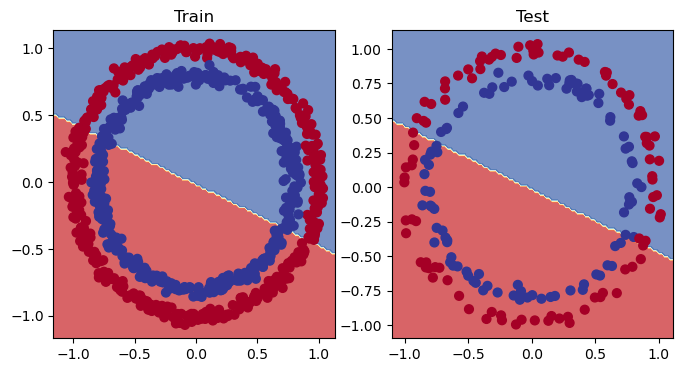

In [34]:
# Model label sayısı, hidden unit sayısı ve epoch sayısını arttırmama rağmen gelişmedi!
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2 ,X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2 ,X_test, y_test)
# Model datayı düz bir çizgi olarak bölmüş o nedenle yüzde 50 lerde başarı aldım. Ama datam circle! 
# underfitting problem.

In [35]:
# Problemi linear ile çözemem. Non-linear! Yeni bir model vakti!
# Relu ile deneyelim
# Build model with non-linear activation function
from torch import nn
class CircleModelV3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV3().to(device)
print(model_3)

CircleModelV3(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


### Playground a gidip bi bakalım ağımıza(tam aynısı değil izin verilen kadar)
<img src="playgroundwithrelu.png" width="700" height="100">

In [36]:
# Set up loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

In [37]:
torch.manual_seed(42)

# Put all data to target device(GPU)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
    # Training
    model_3.train()
    # Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits->pred probs->pred labels
    # Loss and acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    # Optimizer zero grad
    optimizer.zero_grad()
    # Loss backward
    loss.backward()
    # Optimizer
    optimizer.step()
    # Testing
    model_3.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # Calculate loss
        test_loss = loss_fn(test_logits, y_test)
        # Calculate acc
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss: .5f} | Acc: {acc:.2f}% | Test loss: {test_loss: .5f} | Test_Acc: {test_acc:.2f}% ") 

Epoch: 0 | Loss:  0.69295 | Acc: 50.00% | Test loss:  0.69319 | Test_Acc: 50.00% 
Epoch: 100 | Loss:  0.69115 | Acc: 52.88% | Test loss:  0.69102 | Test_Acc: 52.50% 
Epoch: 200 | Loss:  0.68977 | Acc: 53.37% | Test loss:  0.68940 | Test_Acc: 55.00% 
Epoch: 300 | Loss:  0.68795 | Acc: 53.00% | Test loss:  0.68723 | Test_Acc: 56.00% 
Epoch: 400 | Loss:  0.68517 | Acc: 52.75% | Test loss:  0.68411 | Test_Acc: 56.50% 
Epoch: 500 | Loss:  0.68102 | Acc: 52.75% | Test loss:  0.67941 | Test_Acc: 56.50% 
Epoch: 600 | Loss:  0.67515 | Acc: 54.50% | Test loss:  0.67285 | Test_Acc: 56.00% 
Epoch: 700 | Loss:  0.66659 | Acc: 58.38% | Test loss:  0.66322 | Test_Acc: 59.00% 
Epoch: 800 | Loss:  0.65160 | Acc: 64.00% | Test loss:  0.64757 | Test_Acc: 67.50% 
Epoch: 900 | Loss:  0.62362 | Acc: 74.00% | Test loss:  0.62145 | Test_Acc: 79.00% 


In [38]:
# Evaluating model_3
# Makes Predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_pred[:10], y_test[:10]

(tensor([1., 0., 0., 0., 1., 1., 1., 1., 0., 0.], device='mps:0',
        grad_fn=<SliceBackward0>),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='mps:0'))

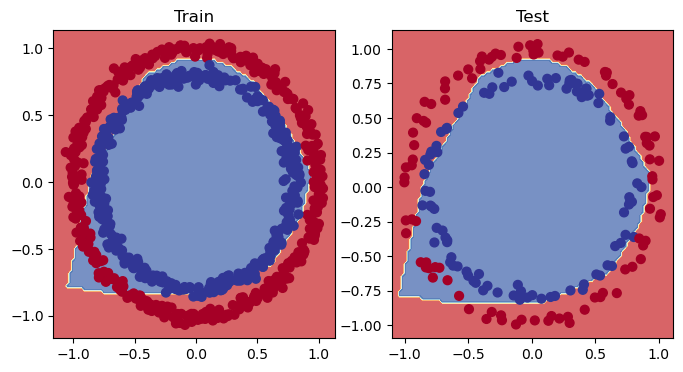

In [39]:
# Plot it
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3 ,X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3 ,X_test, y_test)

In [40]:
# Peki daha fazla acc elde etmek için bu non-linear modeli geliştirmeyi deneyelim. Hidden unit sayısını arttırdım
class CircleModelV4(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=20)
        self.layer_2 = nn.Linear(in_features=20, out_features=20)
        self.layer_3 = nn.Linear(in_features=20, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model 
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_4 = CircleModelV4().to(device)
print(model_4)

CircleModelV4(
  (layer_1): Linear(in_features=2, out_features=20, bias=True)
  (layer_2): Linear(in_features=20, out_features=20, bias=True)
  (layer_3): Linear(in_features=20, out_features=1, bias=True)
  (relu): ReLU()
)


In [41]:
# Set up loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

In [42]:
torch.manual_seed(42)

# Put all data to target device(GPU)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
    # Training
    model_4.train()
    # Forward pass
    y_logits = model_4(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits->pred probs->pred labels
    # Loss and acc
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)
    # Optimizer zero grad
    optimizer.zero_grad()
    # Loss backward
    loss.backward()
    # Optimizer
    optimizer.step()
    # Testing
    model_4.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model_4(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))
        # Calculate loss
        test_loss = loss_fn(test_logits, y_test)
        # Calculate acc
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss: .5f} | Acc: {acc:.2f}% | Test loss: {test_loss: .5f} | Test_Acc: {test_acc:.2f}% ") 

Epoch: 0 | Loss:  0.69448 | Acc: 47.62% | Test loss:  0.69197 | Test_Acc: 54.00% 
Epoch: 100 | Loss:  0.69102 | Acc: 53.12% | Test loss:  0.68961 | Test_Acc: 56.50% 
Epoch: 200 | Loss:  0.68750 | Acc: 56.88% | Test loss:  0.68704 | Test_Acc: 57.00% 
Epoch: 300 | Loss:  0.68379 | Acc: 59.62% | Test loss:  0.68357 | Test_Acc: 59.50% 
Epoch: 400 | Loss:  0.67821 | Acc: 63.12% | Test loss:  0.67807 | Test_Acc: 63.00% 
Epoch: 500 | Loss:  0.66898 | Acc: 69.50% | Test loss:  0.66913 | Test_Acc: 72.00% 
Epoch: 600 | Loss:  0.65292 | Acc: 75.38% | Test loss:  0.65433 | Test_Acc: 77.00% 
Epoch: 700 | Loss:  0.62314 | Acc: 85.62% | Test loss:  0.62753 | Test_Acc: 84.00% 
Epoch: 800 | Loss:  0.56538 | Acc: 94.62% | Test loss:  0.57623 | Test_Acc: 94.00% 
Epoch: 900 | Loss:  0.45988 | Acc: 99.38% | Test loss:  0.48168 | Test_Acc: 98.00% 


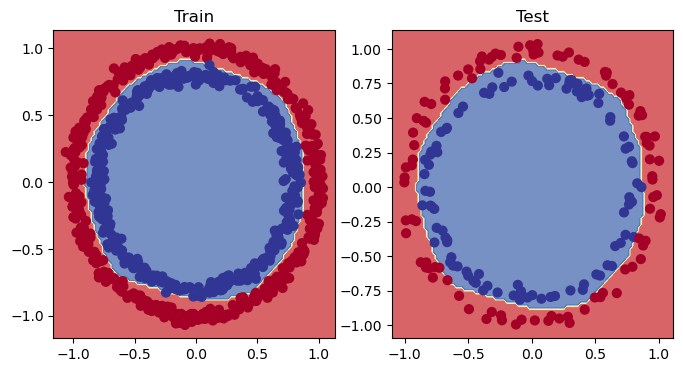

In [43]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4 ,X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4 ,X_test, y_test)
# NICEEE

*  We saw before how adding non-linear activation functions to our model can helped it to model non-linear data.
* Note: Much of the data you'll encounter in the wild is non-linear (or a combination of linear and non-linear). Right now we've been working with dots on a 2D plot. But imagine if you had images of plants you'd like to classify, there's a lot of different plant shapes. Or text from Wikipedia you'd like to summarize, there's lots of different ways words can be put together (linear and non-linear patterns).
* But what does a non-linear activation look like?
* How about we replicate some and what they do?

In [44]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)

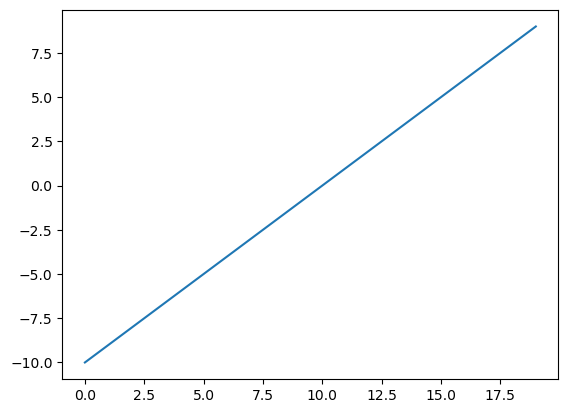

In [45]:
plt.plot(A)
# Bu Linear duruma nasıl Relu uygulayacağım?

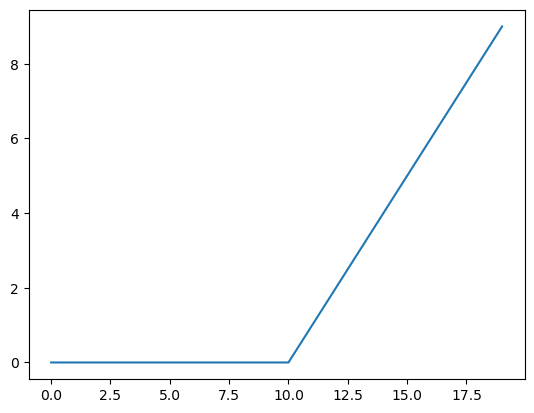

In [46]:
plt.plot(torch.relu(A))

In [47]:
def relu(x: torch.Tensor)-> torch.Tensor:
    return torch.maximum(torch.tensor(0), x) # inputs must be tensor
relu(A) # Tüm - leri 0 yaptı

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

In [48]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

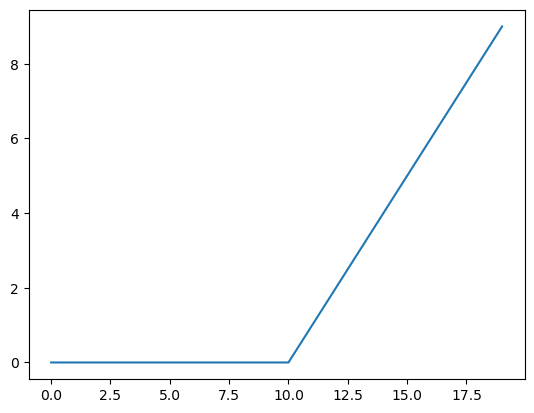

In [49]:
plt.plot(relu(A))

<img src="relu.png" width="500" height="400">
<img src="sigmoid.png" width="500" height="400">

In [50]:
# Şimdi de aynı şeyleri Sigmoid için yapalım
def sigmoid(x):
    return 1 / (1+torch.exp(-x))

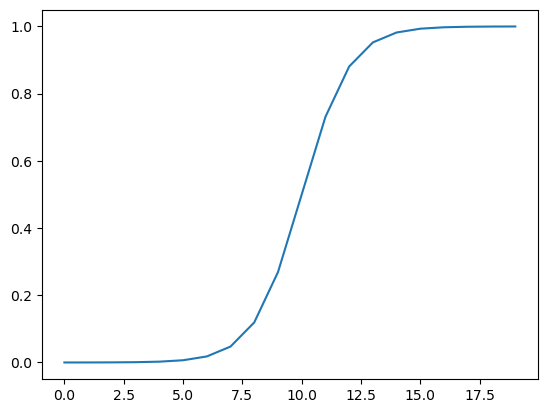

In [51]:
plt.plot(torch.sigmoid(A))

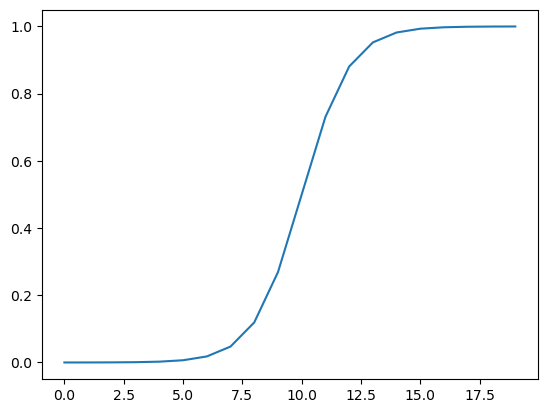

In [52]:
plt.plot(sigmoid(A))

<img src="actsum.png" width="700" height="400">

##  Building a multi-class classification with PyTorch


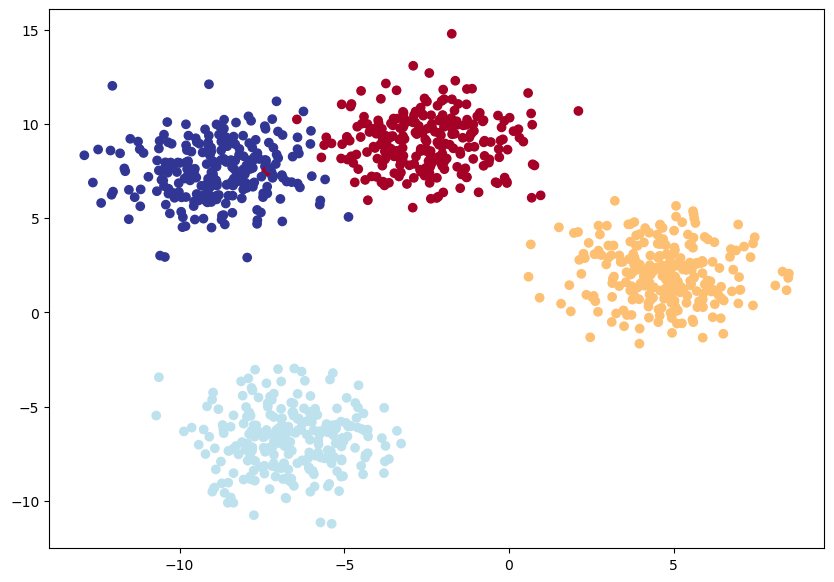

In [53]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES,
                            cluster_std=1.5, random_state=RANDOM_SEED)

# Turn data into the tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED)

plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [54]:
X_blob_train.shape, y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

In [55]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

In [56]:
# Building a model for multi-class classification problem
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_blob_0 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_blob_0

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [57]:
# Create a loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_blob_0.parameters(), lr=0.1)

In [58]:
X_blob_test.device  # Datam Cpu da koşuyor hala

device(type='cpu')

In [59]:
# Lets get some raw outputs of our model(logits)
model_blob_0.eval()
with torch.inference_mode():
    y_logits = model_blob_0(X_blob_test.to(device))
y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]], device='mps:0')

In [60]:
# out_features ı 4 ayarladım. O nedenlr 4 er tane geldi logitler bunlar.
# Burada 4 tane class ın her biri için olasılıklar şeklinde ayarlayacağım softmax ile aşağıda 
y_blob_test[:10]
# Yukarıdakilerin formatını aşağıdakileri gibi yapmalıyım
    # Logits -> pred probs -> pred labels

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [61]:
# Conver our models logits outputs to prediction probs
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='mps:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='mps:0')


In [62]:
# Naptı şimdi Softmax
# Artık elinde negatif değer yok. Elinde pred prob lar var
# Şöyle bir şey deneyelim;
# y_pred_probs[0]  : tensor([0.3169, 0.3244, 0.1405, 0.2182], device='mps:0')
torch.sum(y_pred_probs[0]) # Toplamı 1!!!

tensor(1.0000, device='mps:0')

In [63]:
torch.max(y_pred_probs[0]) # Bunun class ı class 1 diyor olasılıklara bakarsan

tensor(0.3244, device='mps:0')

In [64]:
# Şimdi bu pred prob ları alıp pred label lere çevirelim!
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='mps:0')

In [65]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [66]:
# Create Training and Testing Loop
torch.manual_seed(42)

epochs = 100 

# Put the data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    # Training
    model_blob_0.train()
    
    y_logits = model_blob_0(X_blob_train)
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)
    
    optimizer.zero_grad()
    
    loss.backward()
    optimizer.step()
    
    # Testing
    model_blob_0.eval()
    with torch.inference_mode():
        test_logits = model_blob_0(X_blob_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)
        
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_preds)
    # Prints
    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test Loss: 1.07554, Test Acc: 48.00%
Epoch: 10 | Loss: 0.64476, Acc: 96.75% | Test Loss: 0.66069, Test Acc: 97.50%
Epoch: 20 | Loss: 0.42535, Acc: 98.50% | Test Loss: 0.43074, Test Acc: 100.00%
Epoch: 30 | Loss: 0.25294, Acc: 99.12% | Test Loss: 0.24508, Test Acc: 99.50%
Epoch: 40 | Loss: 0.11232, Acc: 99.25% | Test Loss: 0.10229, Test Acc: 99.50%
Epoch: 50 | Loss: 0.06627, Acc: 99.25% | Test Loss: 0.05848, Test Acc: 99.50%
Epoch: 60 | Loss: 0.05068, Acc: 99.25% | Test Loss: 0.04293, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04300, Acc: 99.25% | Test Loss: 0.03491, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03836, Acc: 99.25% | Test Loss: 0.02988, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03525, Acc: 99.25% | Test Loss: 0.02663, Test Acc: 99.50%


In [67]:
model_blob_0.eval()
with torch.inference_mode():
    y_logits = model_blob_0(X_blob_test)
y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9465],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3762, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='mps:0')

In [68]:
# Go from logits to Prediction Probs
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[1.3437e-03, 9.9865e-01, 1.2163e-06, 5.3853e-07],
        [4.9905e-03, 7.4739e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6059e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1955e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4903e-06, 2.2377e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7988e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5043e-04],
        [9.9825e-01, 1.4575e-03, 1.5997e-05, 2.7210e-04]], device='mps:0')

In [69]:
# Go from pred probs to pred labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='mps:0')

In [70]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='mps:0')

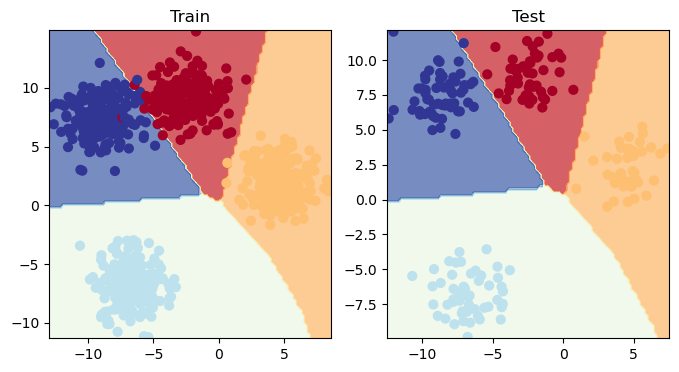

In [71]:
plt.figure(figsize=(8,4))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_blob_0, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_blob_0, X_blob_test, y_blob_test)

##  More classification evaluation metrics

<img src="classificationmetrics.png" width="400" height="400">

<img src="cmetrics.png" width="700" height="400">

In [73]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.2/529.2 kB 2.1 MB/s eta 0:00:0000:0100:01


In [75]:
from torchmetrics import Accuracy

torchmetric_acc.device # Cpu

device(type='cpu')

In [76]:
# Setup metric
torchmetric_acc = Accuracy().to(device)
torchmetric_acc(y_preds, y_blob_test)

tensor(0.9950, device='mps:0')